<a href="https://colab.research.google.com/github/katarinagresova/AgoBind/blob/main/DNABERT_for_CLASH_1_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/katarinagresova/AgoBind

Cloning into 'AgoBind'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 85 (delta 50), reused 61 (delta 26), pack-reused 0
Unpacking objects: 100% (85/85), done.


In [ ]:
!wget https://media.githubusercontent.com/media/ML-Bioinfo-CEITEC/miRBind/main/Datasets/train_set_1_100_CLASH2013_paper.tsv AgoBind/data/train_set_1_100_CLASH2013_paper.tsv
!wget https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/miRBind/main/Datasets/evaluation_set_1_100_CLASH2013_paper.tsv AgoBind/data/evaluation_set_1_100_CLASH2013_paper.tsv

In [ ]:
!pip install comet_ml
!pip install transformers
!pip install matplotlib

In [ ]:
%cd AgoBind

/content/AgoBind


In [ ]:
!python run.py data/train_set_1_100_CLASH2013_paper.tsv data/evaluation_set_1_100_CLASH2013_paper.tsv

Streaming output truncated to the last 5000 lines.
100%|█████████▉| 512/513 [01:16<00:00,  6.62it/s]
                                                        
{'eval_loss': 0.6653242707252502, 'eval_accuracy': 0.6195581546458739, 'eval_f1': 0.6198051948051948, 'eval_precision': 0.6079617834394905, 'eval_recall': 0.6321192052980132, 'eval_auc_pr': 0.7102776613603048, 'eval_runtime': 77.2424, 'eval_samples_per_second': 79.697, 'eval_steps_per_second': 6.641, 'epoch': 0.39}
100%|██████████| 513/513 [01:17<00:00,  6.63it/s]
                                                 Saving model checkpoint to output_checkpoints/checkpoint-200
Configuration saved in output_checkpoints/checkpoint-200/config.json
Model weights saved in output_checkpoints/checkpoint-200/pytorch_model.bin
  0%|          | 300/256500 [10:45<114:51:05,  1.61s/it]***** Running Evaluation *****
  Num examples = 6156
  Batch size = 12

100%|█████████▉| 512/513 [01:16<00:00,  6.69it/s]
                                           

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("./output_checkpoints/checkpoint-900")

In [ ]:
import torch
def preprocess_datasets(dset, tokenizer, kmer_len, stride):
    '''
    Currently 
    AABBC with stride = 2 and kmer = 2 produces
    ['AA','BB'] and cuts off C 
    TODO is this desired? If not, set for cycle limit to len(text) only
    '''

    offset = kmer_len

    #This is where the max_length is computed
    max_seq_len = max([len(dset[i][0]) for i in range(len(dset))])
    max_seq_len = max_seq_len if max_seq_len < 512 else 512 

    if(max_seq_len >=512):
        print('WARNING: some sequences are longer than 512, these are being trimmed')

    def coll(data):
        encoded_dset = [(label, tokenizer([text[i:i+offset] 
                        for i in range(0, len(text)-offset+1, stride)], max_length=max_seq_len, padding="max_length", is_split_into_words=True, truncation=True, verbose=True).input_ids)
                        for text, label in data]
        encoded_samples = [{"input_ids": torch.tensor(ids), "attention_mask": torch.tensor([1]*len(ids)), "labels": torch.tensor(label)} 
                    for label, ids in encoded_dset]

        return encoded_samples

    encoded_samples = coll(dset)

    return encoded_samples

In [ ]:
from transformers import AutoTokenizer
import pandas as pd

test_dset = pd.read_csv('./data/evaluation_set_1_1_CLASH2013_paper.tsv', sep='\t')
test_dset['seq'] = test_dset.apply(lambda x: x['miRNA'] + 'NNNN' + x['gene'], axis=1)

kmer_len = 6
stride = 1
tokenizer = AutoTokenizer.from_pretrained(f"armheb/DNA_bert_{kmer_len}")
test_dset = preprocess_datasets(test_dset[['seq', 'label']].to_numpy(), tokenizer, kmer_len, stride)

In [ ]:
from torch.utils.data import DataLoader, SequentialSampler
from tqdm import tqdm
import numpy as np

def get_predictions_and_labels(test_data, encoded_samples_test, model):
    test_loader = DataLoader(
                encoded_samples_test, 
                sampler = SequentialSampler(encoded_samples_test), 
                batch_size = 4 #TODO increase with your CPU
            )

    predictions = []
    # for sample in tqdm(test_loader, total=len(test_dset)/32):

    for sample in tqdm(test_loader, total=len(test_loader)): 

        outputs = model.to("cpu")(**sample)
        # outputs = model(**sample) #TODO make eval on GPU

        #preds = outputs.logits.argmax(-1).tolist()
        preds = np.array(outputs.logits.tolist())
        predictions.extend(preds)

    labels = pd.read_csv(test_data, sep='\t', usecols=['label']).to_numpy()

    return predictions, labels

In [ ]:
predictions, labels = get_predictions_and_labels('data/evaluation_set_1_1_CLASH2013_paper.tsv', test_dset, model)

100%|██████████| 500/500 [07:59<00:00,  1.04it/s]


In [ ]:
predictions[:5]

[array([-0.32541046,  0.35782683]),
 array([-0.37823331,  0.21696268]),
 array([-0.88424504,  0.97894019]),
 array([-1.46957994,  1.21774077]),
 array([-1.44989038,  1.278754  ])]

In [ ]:
from scipy.special import softmax

probs = softmax(predictions, axis=1)[:, 1]

PRECISIONS: [0.52742616 0.52717678 0.52745512 ... 1.         1.         1.        ]
RECALLS: [1.    0.999 0.999 ... 0.002 0.001 0.   ]


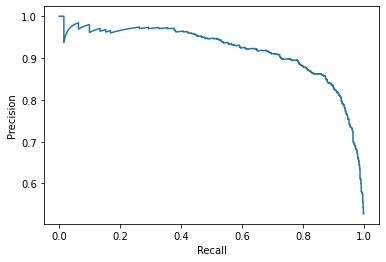

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


plt.figure()

precision, recall, _ = precision_recall_curve(labels, probs)
print("PRECISIONS:", precision)
print("RECALLS:", recall)
plt.plot(recall, precision)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('PR.png')

plt.show()

In [ ]:
!zip /content/dnabert_for_clash_1_1.zip output_checkpoints/checkpoint-900/

  adding: output_checkpoints/checkpoint-900/ (stored 0%)
